<div style="width:image width px; font-size:75%; text-align:right;">
    <img src="img/header.jpg" width="width" height="height" style="padding-bottom:0.2em;" />
    <figcaption>Photo by John Torcasio on Unsplash</figcaption>
</div>

# Relevance of NFL game statistics

**An analysis of typical statistics on NFL games in terms of their impact on the game result**

*Dennis Gluesenkamp*

### Table of contents
* [Introduction](#introduction)
* [Import of libraries and definition of functions](#libraries)
* [Scraping the NFL games data](#scraping)
* [Data preprocessing](#preprocessing)
* [Feature importance analysis](#featureimportance)
* [References](#references)

<img src="img/div.png"/>

### Introduction<a class="anchor" id="introduction"></a>

Nowadays, sports events live above all from their media coverage and the fact that the audience can also watch them live from home. This includes cheering up winners and writing down losers. The reporting of sports events is therefore an essential factor for the popularity of a particular sport and opinions as well as judgements by experts, former professionals or other persons are a good way to polarize, explain or simply be in conversation.

In addition, many sports are now statistically fully screened. Huge amounts of data are collected and systematically evaluated for every game and every player. These figures also influence the reports and comments on the matches. They are used to underpin the own argumentation. But is there any cherry picking here? Are only those statistics used that make the result look completely logical? Are some numbers and statistics used, although they generally have little influence or are even random?

American football in general, and the NFL in particular, is also the subject of a great deal of reporting that is extremely difficult to comprehend. And here too - perhaps even more than in many other sports - statistics serve as argumentation. Typical quotes include:

* *But Philly's defense didn't need much help. The Eagles became the first team in NFL history to record 10 sacks and score two defensive touchdowns in a single game.* [1]
* *On Sunday, Goff passed for a career-low 78 yards in a 20-7 loss to the San Francisco 49ers. [...] Goff completed 13 of 24 passes against the 49ers. His longest completion, to tight end Gerald Everett, covered 12 yards.* [2]
* *Howard had 36 carries and the Bears gained 231 yards on 54 attempts. Baltimore (3-3) trailed 17-3 in the third quarter and 24-16 late in regulation before using two long kick returns to get back in the game.* [3]

However, are the usual statistics like *total yards*, *number of fumbles*, or *pass completion rate* really so meaningful with regard to the outcome? Are there more important and less important variables to explain a result? In summary, the following question is therefore at the heart of this evaluation: *Which team statistics are particularly relevant for explaining the outcome of an NFL game?*

In order to give an initial assessment of this and the accompanying questions, the typical team statistics of NFL games (*boxscores*) are considered part of a simple but easily understandable machine learning approach. This will reveal which features an computational algorithm would access to determine the results of games in the mass as correctly as possible. Thus, these numbers might be used as a solid basis for argumentation, whereas other statistics go rather with the flow and are used depending on the result or not.

<img src="img/div.png"/>

### Import of libraries and definition of functions<a class="anchor" id="libraries"></a>

#### Libraries

In [1]:
# Array operations and useful analysis functionalities
import pandas as pd
import numpy as np

# Web-scraping functionalities
import requests
from selenium import webdriver

# Providing sleeping functionality for the script
import time

# Check for file existance
import os

# Decision tree model and accompanying functionalities
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline

#### Functions
In order to keep the actual code for web scraping manageable and to modularize important, recurring processes, support functions are defined below.

##### Change data type in lists
The function allows to change the data type for objects in a list. Reference for this function goes to Andrew Clark [4].

In [2]:
def changeListType(item, func):
    if isinstance(item, list):
        return [changeListType(x, func) for x in item]
    return func(item)

##### First digit finder
The function allows to find the first numeric value in the score table for a specific game and returns the index a place before this value. Attention: The San Francisco 49ers have to be intercepted, because their name include a number.

In [3]:
def findFirstDigit(s):
    i = 0                        # Start with first character
    b = True                     # Loop variable
    
    while b and i <= len(s):     # Do loop until first numeric index is reached
        b = not s[i].isdigit()   # Check whether current 'char' is numeric
        
        # Test the 49ers case
        if s[i].isdigit() and s[i:i+5] == '49ers':
            b = not b            # Re-set loop variable
            i = i+4              # Skip '49ers' string
            
        i += 1                   # Increment index
        
    return i-1                   # Return the index before first numeric 'char'

##### Whitespace replacement in team names
Team names have whitespaces, which interfere with the following procedures which split the strings into cells of a data frame. Therefore whitespaces in team names are replaced by underscores in this function. It utilizes the digit finder function because the structure of the data table in the sources is as follows: 'Team name, whitespace, scores'

In [4]:
def createUnderscoredTeamname(s):
    snew = s.replace(s[0:findFirstDigit(s)-1],
                     s[0:findFirstDigit(s)-1].replace(' ', '_'))
    
    return snew

##### Cleaning scoreboard string
This functions splits the game string into an away and home team part. Due to the typical scoreboard table

|        |   1 |   2 |   3 |   4 | Final |
| ---    | --- | --- | --- | --- | ---   |
| Team A |   7 |   0 |   7 |   0 |    14 |
| Team B |   0 |   9 |   0 |   0 |     9 |

the team names have to be modified with underscores in order to ensure proper splitting based on whitespaces afterwards. Moreover it checks for overtime and adds if necessary NaNs to the list of strings.

In [5]:
def cleanScores(score_tab):
    # Isolate and modify team names
    away = createUnderscoredTeamname(score_tab[score_tab.find('\n')+1:len(score_tab)].partition('\n')[0]).split(' ')
    home = createUnderscoredTeamname(score_tab[score_tab.find('\n')+1:len(score_tab)].partition('\n')[2]).split(' ')

    # Insert NaN for games without overtime
    if len(away) == 7:                       # Games with OT
        score_string = away + home
    else:                                    # Games without OT
        away.insert(5, np.nan)
        home.insert(5, np.nan)
        score_string = (away + home)
    
    return score_string

##### Creating the scores data frame
In this function, the cleaned scoreboard data is finally written into a data frame and labeled with the corresponding column names. As argument the function gets a list of strings - i.e. all scraped scores, beside the game IDs.

In [6]:
def createScoreDF(raw_ids, raw_scores):

    # Combining the scores with the associated game ID
    for i in range(len(raw_scores)):
        raw_scores[i].insert(0, raw_ids[i])
    
    # Score data frame with column definition
    score_df = pd.DataFrame(raw_scores,
                            columns = ['GameID',
                                       'AwayTeam', 'AwayQ1', 'AwayQ2', 'AwayQ3', 'AwayQ4', 'AwayOT', 'AwayFinal',
                                       'HomeTeam', 'HomeQ1', 'HomeQ2', 'HomeQ3', 'HomeQ4', 'HomeOT', 'HomeFinal'])
    
    # Change column types
    num_columns = ['AwayQ1', 'AwayQ2', 'AwayQ3', 'AwayQ4', 'AwayOT', 'AwayFinal',
                   'HomeQ1', 'HomeQ2', 'HomeQ3', 'HomeQ4', 'HomeOT', 'HomeFinal']
    score_df[num_columns] = score_df[num_columns].apply(pd.to_numeric, errors = 'coerce')
    
    # Calculate additional features
    score_df['AwayHalf']  = score_df['AwayQ1'] + score_df['AwayQ2']
    score_df['HomeHalf']  = score_df['HomeQ1'] + score_df['HomeQ2']
    
    return score_df

##### Cleaning team statistics string
The scraped team stats string has to be cleaned in order to respect the entailed titles, whitespaces, hyphens, and especially multiple peices of information in just a single row. An abbreviated example is shown below.

|              | Team A  | Team B  |
| ---          | ---     | ---     |
| First Downs  |       7 |       8 |
| Rush-Yds-TDs | 20-80-1 | 25-99-0 |
| ...          | ...     | ...     |

In [7]:
def cleanTeamStats(stats_tab):
    # Seperate the title and keep the table body only, split at linebreaks
    stats_lines = stats_tab.partition('\n')[2].split('\n')
    
    team_stats = []
    for i in range(len(stats_lines)):
        # Exclude row titles first
        buffer = (stats_lines[i][findFirstDigit(stats_lines[i]):len(stats_lines[i])]
                           .replace('--', '-§')             # Insert wildcard for negative signed integers
                           .replace(' ', '-')               # Replace whitespaces between seperate figures
                           .replace(':', '-')               # Replace colons in time variable
                           .split('-'))                     # Split all atomic features
        buffer = [sub.replace('§', '-') for sub in buffer]  # Rewind wildcard with minus sign
        team_stats.append(buffer)

    return list(pd.core.common.flatten(team_stats)) # Flatten the string to one dimension

##### Creating the team statistics data frame
In this function, the cleaned team stats data is finally written into a data frame and labeled with the corresponding column names. As argument the function gets a list of strings - i.e. all scraped team stats, beside the game IDs.

In [8]:
def createStatsDF(raw_ids, raw_stats):    
    # Changing the data types in the list to integer
    raw_stats = changeListType(raw_stats, int)
    
    # Combining the stats with the associated game ID
    for i in range(len(raw_stats)):
        raw_stats[i].insert(0, raw_ids[i])
    
    # Stats data frame with column definition
    stats_df = pd.DataFrame(raw_stats,
                            columns = ['GameID',
                                       'AwayFirstDowns', 'HomeFirstDowns',
                                       'AwayRush', 'AwayRushYds', 'AwayRushTD', 'HomeRush', 'HomeRushYds', 'HomeRushTD',
                                       'AwayCmp', 'AwayAtt', 'AwayPassYds', 'AwayPassTD', 'AwayInt',
                                       'HomeCmp', 'HomeAtt', 'HomePassYds', 'HomePassTD', 'HomeInt',
                                       'AwaySacked', 'AwaySackedYds', 'HomeSacked', 'HomeSackedYds',
                                       'AwayNetPassYds', 'HomeNetPassYds',
                                       'AwayTotalNetYds', 'HomeTotalNetYds',
                                       'AwayFumbles', 'AwayFumblesLost', 'HomeFumbles', 'HomeFumblesLost',
                                       'AwaySusTurnovers', 'HomeSusTurnovers',
                                       'AwayPenalties', 'AwayPenaltyYds', 'HomePenalties', 'HomePenaltyYds',
                                       'AwayThirdDownsConv', 'AwayThirdDowns', 'HomeThirdDownsConv', 'HomeThirdDowns',
                                       'AwayFourthDownsConv', 'AwayFourthDowns',
                                       'HomeFourthDownsConv', 'HomeFourthDowns',
                                       'AwayToPMin', 'AwayToPSec', 'HomeToPMin', 'HomeToPSec'
                                      ])
    
    # Calculate additional features
    stats_df['AwayTotalGrossYds'] = stats_df['AwayRushYds'] + stats_df['AwayPassYds']
    stats_df['HomeTotalGrossYds'] = stats_df['HomeRushYds'] + stats_df['HomePassYds']
    stats_df['AwayToPPercentage'] = (stats_df['AwayToPMin'] / 60) + (stats_df['AwayToPSec'] / 3600)
    stats_df['HomeToPPercentage'] = (stats_df['HomeToPMin'] / 60) + (stats_df['HomeToPSec'] / 3600)
    
    return stats_df

<img src="img/div.png"/>

### Scraping the NFL games data<a class="anchor" id="scraping"></a>
In order to carry out an analysis as described above respectively to train an ML model at all, the corresponding data for the games is needed. Thus the information retrieval from the internet is an essential part of this work, the so-called web scraping or web data extraction.

In the following you will find the code to read the necessary team statistics from the page [Pro Football Reference](https://www.pro-football-reference.com/). However, the same statistics can also be obtained from other operators, as they are pure facts about the games. The conditions and explanations [5] provided by the operator have been taken into account. It is of great importance that for all applications of web scraping the legal conditions of the site operators and the copyright are clarified before the beginning of such measures. This must be taken into account in the reader's own projects.

#### Creating URLs for NFL season weeks
The first step is to generate the hyperlinks for the individual match weeks. These follow a clear logic at Pro Football Reference.

In [19]:
week_urls  = []                              # List for week URLs
start_year = 2005                            # Start scraping in this year
end_year   = 2005                            # End scraping in this year

for year in range(start_year, end_year+1):
    for week in range(12, 18):                 # Iterate across selectable weeks of a season
        
        # Compose string for Pro Football Reference website
        url = 'https://www.pro-football-reference.com/years/' + str(year) + '/week_' + str(week) + '.htm'
        
        # Check whether the URL exists and if so, append it to the URL-list
        request = requests.head(url)
        if request.status_code == 200:
            week_urls.append(url)
        
    time.sleep(5.0)                          # Pause website calls due to fair usage

The resulting URL strings look as the following example:

In [20]:
print(week_urls[0])

https://www.pro-football-reference.com/years/2005/week_12.htm


#### Retrieving individual game URLs
Every game week there is a series of matches, with each match being assigned its own URL. These are now retrieved per week of the season from the website. In order to get only the hyperlinks to the single games from the long row of URLs, the label *Final* is used, which identifies them.

In [21]:
game_urls = []                               # List for game URLs
driver    = webdriver.Firefox()              # Open scraping browser

for url in week_urls:
    driver.get(url)                          # Open week overview site
    
    # Find all hyperlinks in the week overview website
    all_href = driver.find_elements_by_tag_name('a')
    
    for i in range(len(all_href)):           # Iterate across all href
        if all_href[i].text == 'Final':      # Select game detail links
            game_urls.append(all_href[i].get_attribute('href'))
    
    time.sleep(1.0)                          # Pause website calls due to fair usage

driver.close()                               # Close scraping browser

The resulting URL strings look as the following example:

In [22]:
print(game_urls[0])

https://www.pro-football-reference.com/boxscores/200511240det.htm


#### Retrieving the actual data
Two tables on each page of a game are important for this analysis:
* Game scores: The general game score table including the results of the quarters, overtime (if applicable), and final; example:

|        |   1 |   2 |   3 |   4 | Final |
| ---    | --- | --- | --- | --- | ---   |
| Team A |   7 |   0 |   7 |   0 |    14 |
| Team B |   0 |   9 |   0 |   0 |     9 |

* Team stats: The table which includes the typical and frequently used statsitics in reports and the media; example:

|              | Team A  | Team B  |
| ---          | ---     | ---     |
| First Downs  |       7 |       8 |
| Rush-Yds-TDs | 20-80-1 | 25-99-0 |
| ...          | ...     | ...     |

In the following, the date of the match and the abbreviation of the home team are used as the game ID. This is also the string identifying the game in the hyperlink of Pro Football Reference, so that it can be easily extracted from it.

The data tables from the website are identified by the xpath and passed to the method of the Selenium package. In this way, the information can be retrieved and processed using the *.text* attribute. (Please refer to the [Selenium documentation](https://seleniumhq.github.io/selenium/docs/api/py/webdriver_remote/selenium.webdriver.remote.webdriver.html) for a more detailed explanation of the method.)

**Personal note:** *When scrapping data from the Internet, I experienced on my private computer that I can't read the data for a whole year and certainly not across seasons. For this reason I have started to read the data in slices of about 6 game weeks and store them on hard disk. Of course it might be possible not to have to do this if the hardware is equipped accordingly or if programming is more efficient. However, my personal view was that this chosen procedure is sufficient for this special project. Due to this approach of an IO-process realized here, the game IDs assigned above were not used. Instead, the games were simply numbered consecutively.*

In [ ]:
# Initiate empty lists for the data strings
id_list    = []                          # List for game IDs
score_data = []                          # List for score data
stats_data = []                          # List for team stats data
driver     = webdriver.Firefox()         # Open scraping browser

for url in game_urls:
    driver.get(url)
    
    # Game IDs
    id_list.append(url.rpartition('/')[2].partition('.')[0])
    
    # Game scores
    scoretext = driver.find_element_by_xpath('/html/body/div[2]/div[4]/div[3]/table').text
    scorefigures = cleanScores(scoretext)
    score_data.append(scorefigures)
        
    # Team stats
    statstext = driver.find_element_by_xpath('//*[@id="div_team_stats"]').text
    statsfigures = cleanTeamStats(statstext)
    stats_data.append(statsfigures)    
    
    time.sleep(2.5)                       # Pause website calls due to fair usage

# Write score data to disk
with open('dat/score_data_2005_03.txt', 'w') as f:
    for item in score_data:
        f.write("%s\n" % item)
f.close()

# Write stats data to disk
with open('dat/stats_data_2005_03.txt', 'w') as f:
    for item in stats_data:
        f.write("%s\n" % item)
f.close()

driver.close()

The intermediate snapshots stored on the hard disk are then read in and appended to each other. This is followed by the formation of data frames, which finally leads to the variable *df*. This is the data frame, which contains all read/scraped data.

In [15]:
# Buffer lists for data attachment
scores = []
stats  = []

# Include following years
start_year = 2008
end_year   = 2018

for year in range(start_year, end_year+1):
    for number in range(1, 4):
        filename_score = 'score_data_' + str(year) + '_0' + str(number) + '.txt'
        filename_stats = 'stats_data_' + str(year) + '_0' + str(number) + '.txt'
        
        # Check existance of file
        if os.path.isfile(filename_score):
            score_file = open(filename_score, 'r')
            score_lines = score_file.read()
            score_buffer = score_lines.replace("'", "").replace(',', '').replace('[', '').replace(']', '').split('\n')
            for line_score in score_buffer:
                if line_score.split(' ') != ['']:
                    scores.append(line_score.split(' '))
                    
            stats_file = open(filename_stats, 'r')
            stats_lines = stats_file.read()
            stats_buffer = stats_lines.replace("'", "").replace(',', '').replace('[', '').replace(']', '').split('\n')
            for line_stats in stats_buffer:
                if line_stats.split(' ') != ['']:
                    stats.append(line_stats.split(' '))
            
            print('Input of year ' + str(year) + ', part ' + str(number) + ' completed')

ids = list(map(str, range(len(scores))))          # Generate consecutive numbers as IDs
score_df = createScoreDF(ids, scores)             # Create data frame for scores
stats_df = createStatsDF(ids, stats)              # Create data frame for stats

df = pd.merge(score_df, stats_df, on = 'GameID')  # Merge data frames

Input year 2008, part 1 completed
Input year 2008, part 2 completed
Input year 2008, part 3 completed
Input year 2009, part 1 completed
Input year 2009, part 2 completed
Input year 2009, part 3 completed
Input year 2010, part 1 completed
Input year 2010, part 2 completed
Input year 2010, part 3 completed
Input year 2011, part 1 completed
Input year 2011, part 2 completed
Input year 2011, part 3 completed
Input year 2012, part 1 completed
Input year 2012, part 2 completed
Input year 2012, part 3 completed
Input year 2013, part 1 completed
Input year 2013, part 2 completed
Input year 2013, part 3 completed
Input year 2014, part 1 completed
Input year 2014, part 2 completed
Input year 2014, part 3 completed
Input year 2015, part 1 completed
Input year 2015, part 2 completed
Input year 2015, part 3 completed
Input year 2016, part 1 completed
Input year 2016, part 2 completed
Input year 2016, part 3 completed
Input year 2017, part 1 completed
Input year 2017, part 2 completed
Input year 201

Here is a brief view on the first rows of the composed data frame:

In [20]:
df.head(5)

,GameID,AwayTeam,AwayQ1,AwayQ2,AwayQ3,AwayQ4,AwayOT,AwayFinal,HomeTeam,HomeQ1,...,AwayThirdDownConvRate,HomeThirdDownConvRate,AwayFourthDownConvRate,HomeFourthDownConvRate,AwayYdsPerRun,HomeYdsPerRun,AwayPassYdsPerCmp,HomePassYdsPerCmp,AwayTDIntRatio,HomeTDIntRatio
0,0,Washington_Redskins,0,7,0,0,NaN,7,New_York_Giants,10,...,0.230769,0.500000,0.5,NaN,3.500000,4.812500,8.333333,10.526316,inf,0.0
1,1,Houston_Texans,0,3,0,14,NaN,17,Pittsburgh_Steelers,7,...,0.300000,0.600000,0.0,NaN,3.750000,4.692308,6.360000,9.384615,0.5,inf
2,2,St._Louis_Rams,0,0,0,3,NaN,3,Philadelphia_Eagles,14,...,0.000000,0.571429,NaN,NaN,2.400000,3.375000,9.285714,15.923077,NaN,inf
3,3,Kansas_City_Chiefs,0,3,0,7,NaN,10,New_England_Patriots,0,...,0.500000,0.538462,0.0,NaN,3.777778,4.500000,9.578947,10.600000,1.0,inf
4,4,Tampa_Bay_Buccaneers,7,3,3,7,NaN,20,New_Orleans_Saints,7,...,0.166667,0.384615,0.0,NaN,7.300000,3.740741,8.583333,14.652174,1.0,3.0


In [138]:
##########################################################################################
# Here, the actual files can be named for input
file_names = [
    'nflstats_2010_2011.csv',
    'nflstats_2010_2011.csv'
]

# Iterate across all given filenames
for i, file in enumerate(file_names):
    if i == 0:
        df = pd.DataFrame(columns = ['GameID',
                                     'AwayTeam', 'AwayQ1', 'AwayQ2', 'AwayQ3', 'AwayQ4', 'AwayOT', 'AwayFinal',
                                     'HomeTeam', 'HomeQ1', 'HomeQ2', 'HomeQ3', 'HomeQ4', 'HomeOT', 'HomeFinal',
                                     'AwayHalf', 'HomeHalf',
                                     'AwayFirstDowns', 'HomeFirstDowns',
                                     'AwayRush', 'AwayRushYds', 'AwayRushTD', 'HomeRush', 'HomeRushYds', 'HomeRushTD',
                                     'AwayCmp', 'AwayAtt', 'AwayPassYds', 'AwayPassTD', 'AwayInt',
                                     'HomeCmp', 'HomeAtt', 'HomePassYds', 'HomePassTD', 'HomeInt',
                                     'AwaySacked', 'AwaySackedYds', 'HomeSacked', 'HomeSackedYds',
                                     'AwayNetPassYds', 'HomeNetPassYds', 'AwayTotalNetYds', 'HomeTotalNetYds',
                                     'AwayFumbles', 'AwayFumblesLost', 'HomeFumbles', 'HomeFumblesLost',
                                     'AwaySusTurnovers', 'HomeSusTurnovers',
                                     'AwayPenalties', 'AwayPenaltyYds', 'HomePenalties', 'HomePenaltyYds',
                                     'AwayThirdDownsConv', 'AwayThirdDowns', 'HomeThirdDownsConv', 'HomeThirdDowns',
                                     'AwayFourthDownsConv', 'AwayFourthDowns', 'HomeFourthDownsConv', 'HomeFourthDowns',
                                     'AwayToPMin', 'AwayToPSec', 'HomeToPMin', 'HomeToPSec',
                                     'AwayTotalGrossYds', 'HomeTotalGrossYds',
                                     'AwayToPPercentage', 'HomeToPPercentage'
                                    ])
    
    # Concatenate the data and drop duplicate games if present
    df = pd.concat([df, pd.read_csv('dat/' + file, header = 0)], sort = False).drop_duplicates()

# Set correct data types
types = pd.read_csv('dat/nflstats_dtypes.csv', header = 0, index_col = 0).to_dict()['dtypes']
df = df.astype(types, copy = False)
###########################################################################################

<img src="img/img_sep.png"/>

### Data preprocessing<a class="anchor" id="preprocessing"></a>
At this point there is now a data frame, which summarizes the team statistics for each game in a single row. It is now necessary to make different operations of data preprocessing so that as a result a data frame is obtained which can serve as a basis for machine learning.

To this end, it should be recalled how such statistics are used as a basis for argument, among other things: The win or loss of a team is reasoned with the fact that a certain result was achieved in the respective statistical dimension. This means that the data frame must be adapted in such a way that the values of a single team are recorded as an observation in each row and this row is labelled with the game result *Win/Loss/Draw*.

For this reason, both the away and home team data frames are created from the individual perspectives. Perspective in this context means that the features are renamed to *Own* and *Opponent (Opp)* attributes. Thus, both data frames can be combined afterwards, since one line represents exactly one team in a game with the matching features.

In [40]:
# Additional features before renaming
df['AwayPlays']              = df['AwayRush'] + df['AwayAtt']
df['HomePlays']              = df['HomeRush'] + df['HomeAtt']
df['AwayTD']                 = df['AwayRushTD'] + df['AwayPassTD']
df['HomeTD']                 = df['HomeRushTD'] + df['HomePassTD']
df['AwayThirdDownConvRate']  = df['AwayThirdDownsConv'] / df['AwayThirdDowns']
df['HomeThirdDownConvRate']  = df['HomeThirdDownsConv'] / df['HomeThirdDowns']
df['AwayFourthDownConvRate'] = df['AwayFourthDownsConv'] / df['AwayFourthDowns']
df['HomeFourthDownConvRate'] = df['HomeFourthDownsConv'] / df['HomeFourthDowns']
df['AwayYdsPerRun']          = df['AwayRushYds'] / df['AwayRush']
df['HomeYdsPerRun']          = df['HomeRushYds'] / df['HomeRush']
df['AwayPassYdsPerCmp']      = df['AwayNetPassYds'] / df['AwayCmp']
df['HomePassYdsPerCmp']      = df['HomeNetPassYds'] / df['HomeCmp']
df['AwayYdsPerPlay']         = df['AwayTotalNetYds'] / df['AwayPlays']
df['HomeYdsPerPlay']         = df['HomeTotalNetYds'] / df['HomePlays']
df['AwayTDIntRatio']         = df['AwayPassTD'] / df['AwayInt']
df['HomeTDIntRatio']         = df['HomePassTD'] / df['HomeInt']

# Away team
df_away = (df.rename(columns = lambda x: x.replace('Away', 'Own'))
             .rename(columns = lambda x: x.replace('Home', 'Opp')))

# Home team
df_home = (df.rename(columns = lambda x: x.replace('Away', 'Opp'))
             .rename(columns = lambda x: x.replace('Home', 'Own')))

# Additional features after renaming
df_away['HomeFieldAdvantage'] = 0
df_home['HomeFieldAdvantage'] = 1
df_away['HalfDiff']           = df_away['OwnHalf'] - df_away['OppHalf']
df_home['HalfDiff']           = df_home['OwnHalf'] - df_home['OppHalf']
df_away['FinalDiff']          = df_away['OwnFinal'] - df_away['OppFinal']
df_home['FinalDiff']          = df_home['OwnFinal'] - df_home['OppFinal']

# Win/loss label
# loss = -1, draw = 0, win = 1
res_GameResult = [-1, 0, 1]

cond_GameResultAway = [
    (df_away['OwnFinal'] - df_away['OppFinal'] < 0),
    (df_away['OwnFinal'] - df_away['OppFinal'] == 0),
    (df_away['OwnFinal'] - df_away['OppFinal'] > 0)]
df_away['OwnGameResult'] = np.select(cond_GameResultAway, res_GameResult)

cond_GameResultHome = [
    (df_home['OwnFinal'] - df_home['OppFinal'] < 0),
    (df_home['OwnFinal'] - df_home['OppFinal'] == 0),
    (df_home['OwnFinal'] - df_home['OppFinal'] > 0)]
df_home['OwnGameResult'] = np.select(cond_GameResultHome, res_GameResult)

Now the two data frames are finally attached to each other. In addition, only one of the two teams will be randomly selected for each game (setting the seed ensures reproducibility).

In [41]:
# Concatenate away and home teams
df_teamstats = pd.concat([df_away, df_home], sort = False)

# Creating random column as selector for one of the two teams of a game
np.random.seed(42)

df_selector           = pd.DataFrame(df_teamstats.loc[:, 'GameID']).drop_duplicates()
df_selector['random'] = np.random.uniform(size = df_selector.shape[0])
df_teamstats          = pd.merge(df_teamstats, df_selector, how = 'left', on = 'GameID')

res_teamsplit  = [0.0, 1.0]
cond_teamsplit = [
    (df_teamstats['HomeFieldAdvantage'] == 'no'),
    (df_teamstats['HomeFieldAdvantage'] == 'yes')]
df_teamstats['teamsplit'] = np.select(cond_teamsplit, res_teamsplit)
df_teamstats['select']    = abs(df_teamstats['random'] - df_teamstats['teamsplit'])

# Select only one half
df_teamstats = df_teamstats[df_teamstats.select > 0.5]
df_teamstats.reset_index(inplace = True)

# Drop columns of no further relevance
df_teamstats.drop(['index', 'GameID', 'OwnTeam', 'OppTeam', 'random', 'teamsplit', 'select'],
                  axis = 1, inplace = True)

#### Imputation
Due to divisions of or by zero, the objects inf and NaN are created in the data set. In order to deal with these positions in the classification problem, they should be replaced. For this purpose, the columns in which these objects occur are discussed:
* **Own/OppOT:** If no overtime has taken place, no value is entered here so far, which leads to the creation of NaNs. In the following, we will not examine whether the occurrence of overtime is a factor for the final result. This line of argument could not be found in the relevant statistics pages. For this reason the NaNs are replaced here by zeros.
* **Own/OppFourthDownConvRate:** At the conversion rate of the fourth downs an empty entry and thus a NaN is reached by the fact that the respective team played out one or more fourth downs, but could not convert any. Therefore a zero should be taken over.
* **Own/OppTDIntRatio:** Both NaNs and inf can be achieved at the touchdown interception ratio. NaNs are formed when no touchdown is achieved. Therefore the ratio is set to zero. Infinite values are reached if at least one touchdown was achieved but no interception was thrown. Since this is the optimal case, a separate value is calculated to take this performance into account. The number of scored touchdowns is taken and increased by 0.5. Thus the player's level is better than someone who achieved the same number of touchdowns on one interception, but under a player with a higher number of touchdowns and no or only one interception.

In [42]:
mask_own = df_teamstats['OwnTDIntRatio'] == np.inf
df_teamstats.loc[mask_own, 'OwnTDIntRatio'] = df_teamstats.loc[mask_own, 'OwnPassTD']+0.5

mask_opp = df_teamstats['OppTDIntRatio'] == np.inf
df_teamstats.loc[mask_opp, 'OppTDIntRatio'] = df_teamstats.loc[mask_opp, 'OppPassTD']+0.5

df_teamstats.fillna(0, inplace = True)

Here you can see the first rows of the final data frame:

In [43]:
df_teamstats.head(5)

,OwnQ1,OwnQ2,OwnQ3,OwnQ4,OwnOT,OwnFinal,OppQ1,OppQ2,OppQ3,OppQ4,...,OwnPlays,OppPlays,OwnPassYdsPerPlay,OppPassYdsPerPlay,OwnYdsPerPlay,OppYdsPerPlay,HomeFieldAdvantage,HalfDiff,FinalDiff,OwnGameResult
0,0,3,0,14,0.0,17,7,14,14,3,...,53,57,4.415094,5.350877,4.415094,5.350877,0,-18,-21,-1
1,0,0,0,3,0.0,3,14,7,10,7,...,41,71,4.048780,7.352113,4.048780,7.352113,0,-21,-35,-1
2,0,3,0,7,0.0,10,0,7,7,3,...,58,57,4.896552,5.929825,4.896552,5.929825,0,-4,-7,-1
3,0,14,7,0,0.0,21,21,0,10,3,...,54,55,5.851852,8.618182,5.851852,8.618182,0,-7,-13,-1
4,0,7,0,3,0.0,10,3,7,0,7,...,52,56,3.634615,5.517857,3.634615,5.517857,0,-3,-7,-1


#### Write and read data frame as csv file
In order to store the data frame intermediately, it is possible to write a csv file via an export including another file for the column types.

In [172]:
df_teamstats.to_csv('dat/teamstats.csv', sep = ',', index = False)
df_teamstats.dtypes.to_frame('dtypes').to_csv('dat/teamstats_dtypes.csv', sep = ',')

<img src="img/img_sep.png"/>

### Feature importance analysis<a class="anchor" id="featureimportance"></a>
After the data frame with the boxscores read out from Pro Football Reference was constructed in the last section above, the analysis steps now follow to answer the central question: *Which team statistics are particularly relevant for the explanation of the outcome of an NFL game?*

#### Selection of media-typical figures
First, the data frame is reduced to the features/statistics that are usually used in media coverage. A selection has been made which does not claim to be complete. Neither was a systematic quantitative evaluation made of what figures occur where and how frequently in the media. Nevertheless, in my opinion, this selection reflects the typically used statistical values quite well.

In [46]:
df_select = df_teamstats.loc[:,['OwnToPPercentage', 'OwnTotalNetYds', 'OppTotalNetYds',
                                'OwnFumbles', 'OwnFumblesLost', 'OppFumbles', 'OppFumblesLost',
                                'OwnTD', 'OppTD', 'OwnInt', 'OppInt', 'OwnYdsPerPlay', 'OppYdsPerPlay',
                                'OwnRushYds', 'OppRushYds', 'OwnPassYds', 'OppPassYds',
                                'OwnPenalties', 'OwnPenaltyYds', 'OppPenalties', 'OppPenaltyYds',
                                'OwnPlays', 'OppPlays', 'OwnAtt', 'OppAtt', 'OwnCmp', 'OppCmp',
                                'OwnNetPassYds', 'OppNetPassYds', 'OwnPassYdsPerCmp', 'OppPassYdsPerCmp',
                                'OwnRush', 'OppRush', 'OwnYdsPerRun', 'OppYdsPerRun',
                                'OwnThirdDownConvRate', 'OppThirdDownConvRate',
                                'OwnFourthDownConvRate', 'OppFourthDownConvRate', 'OwnSacked', 'OppSacked',
                                'OwnGameResult']]
df_select.head(5)

,OwnToPPercentage,OwnTotalNetYds,OppTotalNetYds,OwnFumbles,OwnFumblesLost,OppFumbles,OppFumblesLost,OwnTD,OppTD,OwnInt,...,OppRush,OwnYdsPerRun,OppYdsPerRun,OwnThirdDownConvRate,OppThirdDownConvRate,OwnFourthDownConvRate,OppFourthDownConvRate,OwnSacked,OppSacked,OwnGameResult
0,0.474722,234,305,1,1,3,1,2,5,2,...,39,3.750000,4.692308,0.300000,0.600000,0.0,0.0,5,2,-1
1,0.413889,166,522,1,0,1,0,0,5,0,...,32,2.400000,3.375000,0.000000,0.571429,0.0,0.0,4,0,-1
2,0.503056,284,338,0,0,3,2,1,2,1,...,28,3.777778,4.500000,0.500000,0.538462,0.0,0.0,4,2,-1
3,0.514722,316,474,1,0,0,0,3,4,1,...,42,3.333333,7.571429,0.222222,0.333333,0.0,0.0,3,1,-1
4,0.522222,189,309,1,1,1,0,1,2,2,...,32,1.941176,4.281250,0.357143,0.230769,1.0,0.0,7,1,-1


#### Correlation between features and label

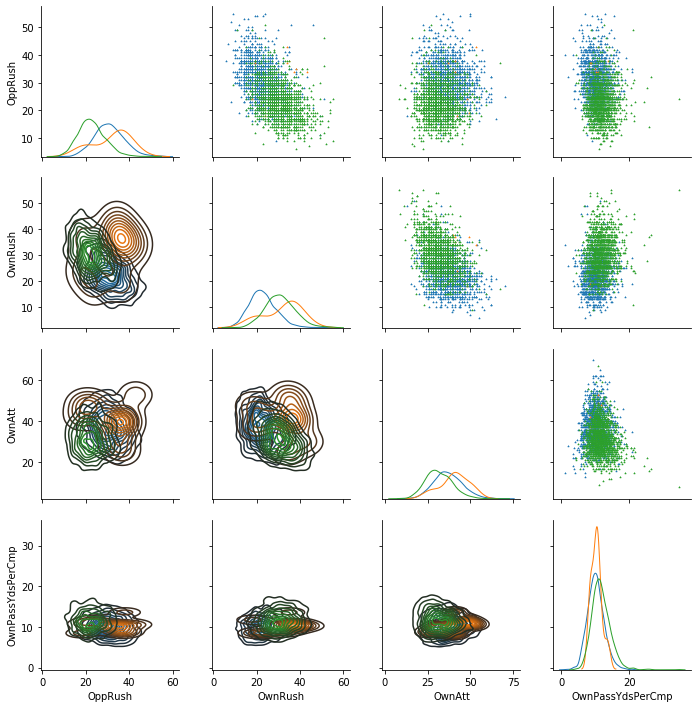

In [107]:
g = sns.PairGrid(df_select, vars = ['OppRush', 'OwnRush', 'OwnAtt', 'OwnPassYdsPerCmp'], hue = 'OwnGameResult')
g = g.map_upper(plt.scatter, marker = '1', s = 2)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.kdeplot, lw = 1)

In [109]:
correlation_matrix = df_select.corr()
top_corr_features = correlation_matrix.index

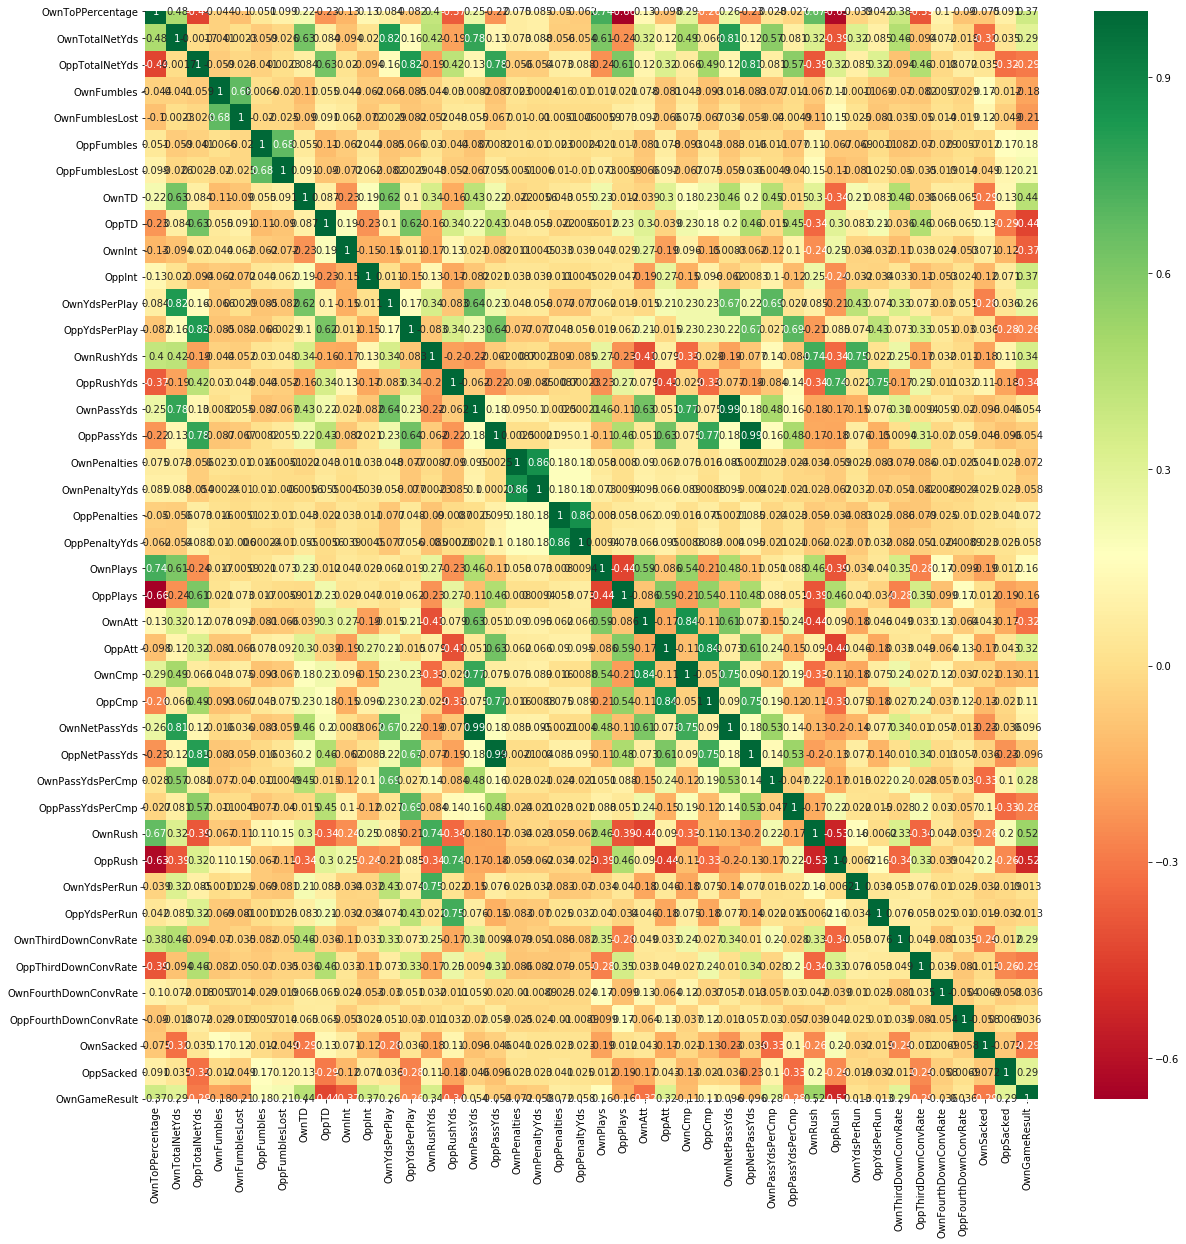

In [114]:
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_select[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [78]:
X = np.array(df_select)[:,:-1]
y = np.array(df_select)[:,-1]

clf = tree.DecisionTreeClassifier()

In [79]:
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [83]:
clf.feature_importances_

array([0.01547126, 0.01902966, 0.01132771, 0.00598259, 0.01226048,
       0.01154156, 0.00800807, 0.08119914, 0.07974365, 0.01302196,
       0.02843135, 0.01077043, 0.0224043 , 0.01786251, 0.00774099,
       0.00979712, 0.00303579, 0.00681888, 0.00926656, 0.00810717,
       0.01681797, 0.011322  , 0.00755629, 0.0193163 , 0.03495486,
       0.01041802, 0.00649027, 0.00330432, 0.01575557, 0.03216926,
       0.01966593, 0.11809066, 0.24731669, 0.01927002, 0.0155482 ,
       0.02044257, 0.0062998 , 0.00165507, 0.00257524, 0.00564775,
       0.00356201])

In [89]:
pd.DataFrame(clf.feature_importances_,
             columns = ['FeatureImportance'],
             index = list(df_select.columns)[:-1]).sort_values('FeatureImportance', ascending = False)

,FeatureImportance
OppRush,0.247317
OwnRush,0.118091
OwnTD,0.081199
OppTD,0.079744
OppAtt,0.034955
OwnPassYdsPerCmp,0.032169
OppInt,0.028431
OppYdsPerPlay,0.022404
OwnThirdDownConvRate,0.020443
OppPassYdsPerCmp,0.019666


In [60]:
from sklearn.base import clone 

def imp_df(column_names, importances):
    df = (pd.DataFrame({'feature': column_names,
                        'feature_importance': importances})
                       .sort_values('feature_importance', ascending = False)
                       .reset_index(drop = True))
    return df

def drop_col_feat_imp(model, X_train, y_train, column_names, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(column_names, importances)
    return importances_df

In [59]:
n = list(df_select.columns)
X = np.array(df_select)[:,:-2]
y = np.array(df_select)[:,-1]

In [54]:
clf = tree.DecisionTreeClassifier()

In [61]:
res = drop_col_feat_imp(clf, X, y, n)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [155]:
from sklearn import tree

In [122]:
X = np.array(df_select)[:,:-1]
y = np.array(df_select)[:,-1]

features = list(df_select.columns)[:-1]
label_classes = ['Loss', 'Draw', 'Win']

In [117]:
clf = tree.DecisionTreeClassifier(max_depth = 5)

[Text(167.4, 199.32, 'X[32] <= 26.5\nentropy = 0.504\nsamples = 2840\nvalue = [1415, 10, 1415]'),
 Text(83.7, 163.07999999999998, 'X[31] <= 24.5\nentropy = 0.385\nsamples = 1441\nvalue = [371, 3, 1067]'),
 Text(41.85, 126.83999999999999, 'X[10] <= 1.5\nentropy = 0.497\nsamples = 309\nvalue = [175, 2, 132]'),
 Text(20.925, 90.6, 'X[5] <= 1.5\nentropy = 0.455\nsamples = 238\nvalue = [157, 2, 79]'),
 Text(10.4625, 54.359999999999985, 'X[24] <= 46.5\nentropy = 0.359\nsamples = 151\nvalue = [116, 1, 34]'),
 Text(5.23125, 18.119999999999976, 'entropy = 0.289\nsamples = 137\nvalue = [113, 0, 24]'),
 Text(15.693750000000001, 18.119999999999976, 'entropy = 0.439\nsamples = 14\nvalue = [3, 1, 10]'),
 Text(31.387500000000003, 54.359999999999985, 'X[12] <= 6.384\nentropy = 0.51\nsamples = 87\nvalue = [41, 1, 45]'),
 Text(26.15625, 18.119999999999976, 'entropy = 0.471\nsamples = 64\nvalue = [22, 1, 41]'),
 Text(36.61875, 18.119999999999976, 'entropy = 0.287\nsamples = 23\nvalue = [19, 0, 4]'),
 Tex

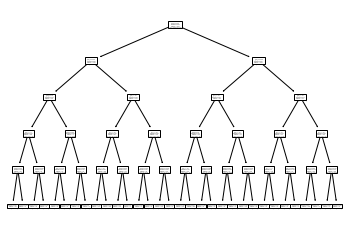

In [121]:
%matplotlib inline
tree.plot_tree(clf.fit(X, y))

In [271]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [303]:
X = np.array(df_teamstats.loc[:,'OwnFirstDowns':'OppTDIntRatio'])
y = np.array(df_teamstats)[:,-1]

X_names = df_teamstats.loc[:,'OwnFirstDowns':'OppTDIntRatio'].columns.str.cat(sep = ',').split(',')
y_names = ['Loss', 'Draw', 'Win']

In [123]:
clf = tree.DecisionTreeClassifier(max_depth = 6)
clf = clf.fit(X, y)

In [124]:
tree.export_graphviz(
            clf,
            out_file =  "depth6.dot",
            feature_names = features,
            class_names = label_classes,
            filled = True,
            rounded = True)

In [328]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state = 42)

clf_tts = tree.DecisionTreeClassifier(max_depth = 4)
clf_tts = clf.fit(X_train, y_train)

In [365]:
clf_tts.feature_importances_

array([0.        , 0.        , 0.48890514, 0.        , 0.        ,
       0.17539413, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02885812, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02434004, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11118653, 0.        , 0.07783526, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00990657,
       0.        , 0.        , 0.00647781, 0.        , 0.        ,
       0.03540859, 0.0416878 ])

In [329]:
y_pred = clf_tts.predict(X_test)

In [330]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7761674718196457


In [139]:
df_select.loc[:, ['OwnRush', 'OwnGameResult']]

,OwnRush,OwnGameResult
0,20,-1
1,15,-1
2,27,-1
3,21,-1
4,17,-1
...,...,...
2835,20,1
2836,27,1
2837,25,-1
2838,34,1


/home/dennis/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 32'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


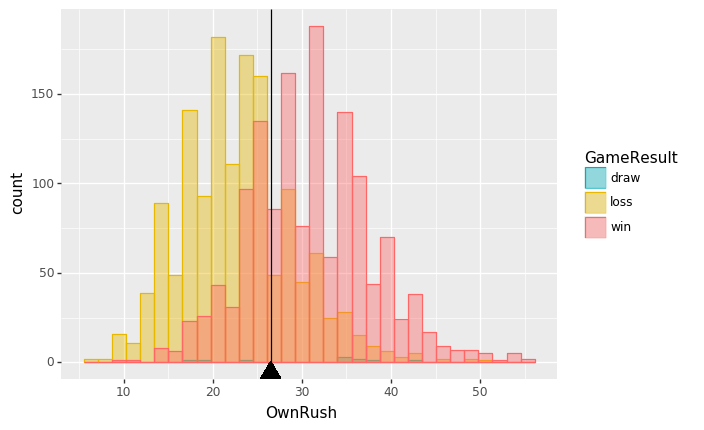

<ggplot: (-9223363290219793962)>

In [173]:
df_viz = df_select
res_result  = ['loss', 'draw', 'win']
cond_result = [
    (df_viz['OwnGameResult'] < 0),
    (df_viz['OwnGameResult'] == 0),
    (df_viz['OwnGameResult'] > 0)]
df_viz['GameResult'] = np.select(cond_result, res_result)
df_viz.to_csv('dat/df_viz.csv', sep = ',', index = False)

(
    ggplot(df_viz)
    + geom_histogram(aes(x = 'OwnRush', color = 'GameResult', fill = 'GameResult'),
                     alpha = 0.4,
                     position = 'identity')
    + geom_vline(xintercept = 26.5)
    + geom_segment(aes(x = 26.5, xend = 26.5,
                       y = -0.0025, yend = 0),
                   arrow = arrow(type = 'closed'))
    + scale_fill_manual(values = ['#00AFBB', '#E7B800', '#FF6666'])
    + scale_color_manual(values = ['#00AFBB', '#E7B800', '#FF6666'])
)

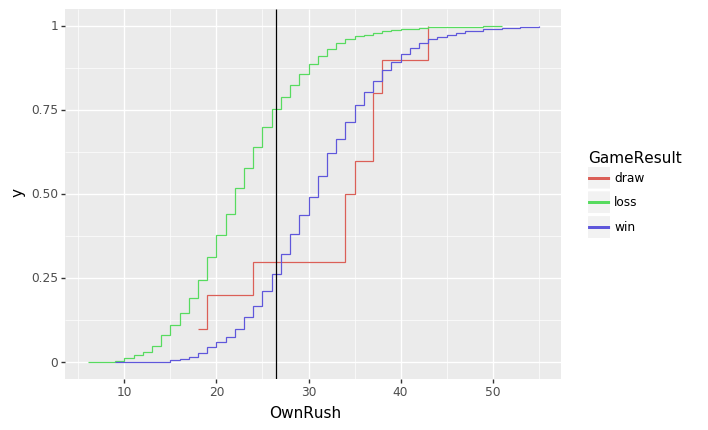

<ggplot: (8746634247144)>

In [171]:
(
    ggplot(df_viz)
    + stat_ecdf(aes(x = 'OwnRush', color = 'GameResult'))
    + geom_vline(xintercept = 26.5)
)

In [127]:
sns.distplot(df_teamstats.loc[:,'OwnRush'], hue = 'OwnGameResult')
plt.axvline(26.5, 0, 1)

TypeError: distplot() got an unexpected keyword argument 'hue'

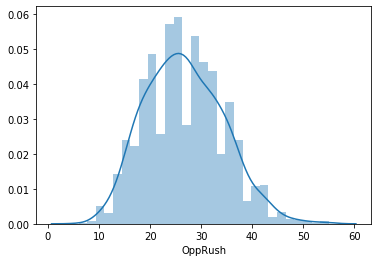

In [306]:
sns.distplot(df_teamstats.loc[:,'OppRush'])

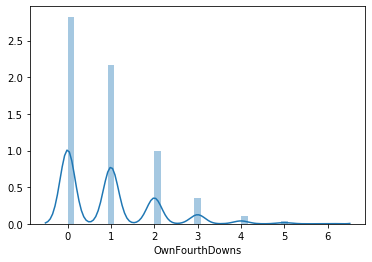

In [307]:
sns.distplot(df_teamstats.loc[:,'OwnFourthDowns'])

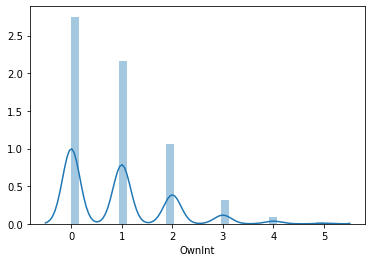

In [308]:
sns.distplot(df_teamstats.loc[:,'OwnInt'])

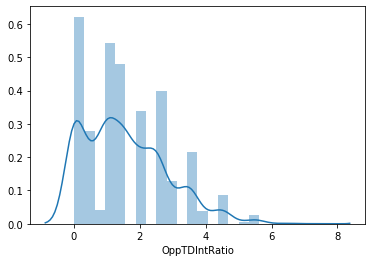

In [309]:
sns.distplot(df_teamstats.loc[:,'OppTDIntRatio'])

<img src="img/img_sep.png"/>

### References<a class="anchor" id="references"></a>
[1] MAADDI, Rob. Defense dominates, Eagles rout Jets 31-6. New York Times, 2019. https://bit.ly/35J1qWy (Accessed on 17 October 2019)

[2] KLEIN, Gary. Jared Goff’s erratic passing leads Rams to throws of defeat against 49ers, 2019. https://lat.ms/33GbYE2  (Accessed on 17 October 2019)

[3] Associated Press/ESPN. Bears beat Ravens 27-24 in OT, 2017. https://es.pn/2MmvFex (Accessed on 17 October 2019)

[4] CLARK, Andrew. Answer to: Python change type of whole list?, 2011. https://stackoverflow.com/a/7422640 (Accessed on 15 October 2019)

[5] Sports Reference. SR and Data Use, 2019. https://www.sports-reference.com/data_use.html (Accessed on 17 October 2019)